# Project of Machine Learning : Adversarial attacks

### Loading of our Classic CNN over Cfar10 dataset

#### Loading data and Normalizing

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch.optim as optim
from tqdm import tqdm
import os

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
     name=fn, length=len(uploaded[fn])))

Saving cifar_net_CLASSIC_10epochs.pth to cifar_net_CLASSIC_10epochs.pth
User uploaded file "cifar_net_CLASSIC_10epochs.pth" with length 683061 bytes


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# functions to show an image

def imshow(img, count=None, categorie=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if count != None and categorie != None :
      plt.savefig("{}_images_{}".format(count, categorie))
    plt.show()

def imsave(img, count=None, categorie=None):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if count != None and categorie != None :
      plt.savefig("{}_images_{}".format(count, categorie), dpi=1000)
    #plt.show()

#### Clean definition of all the iterator over Data

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets


def data_loading(set_data, repartition_train_valid, b_size, training=False, attacked=False, attack=None):
  if training :
    print("\nLoading of Training and Validation sets !")
    datasets = train_val_dataset(set_data, repartition_train_valid)
    dataloaders = {x : torch.utils.data.DataLoader(datasets[x], batch_size=b_size, shuffle=True, num_workers=2) for x in ['train','val']}
    trainloader = dataloaders['train']
    validloader = dataloaders['val']
    return trainloader, validloader
  
  else :
    print("\nLoading of the Test set !")
    testloader = torch.utils.data.DataLoader(set_data, batch_size=b_size,
                                              shuffle=True, num_workers=2)
    return testloader

#### Class of our CNN

In [ ]:
class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.dropout1 = nn.Dropout(p=0.2, inplace=False)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout1(x)
        x = x.view(-1, 128 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
      

    def fit(self, train_set, test_set, batch_size, nb_epochs, criterion, learning_r):
      train, valid = data_loading(train_set, 0.1, batch_size, training=True)
      test = data_loading(test_set, 0.1, batch_size, training=False)
      optimizer = optim.SGD(self.parameters(), lr=learning_r, momentum=0.9)
      
      loss_total = []
      valid_loss_total = []
      acc_total = []

      for epoch in range(nb_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        valid_loss = 0.0
        temp = []
        for i, data in enumerate(train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = self.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          nbr_ref = int(( 5400 / (batch_size / 4) ))

          if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / nbr_ref ))
              
              temp.append(running_loss/nbr_ref)
              running_loss = 0.0
        loss_total.append(np.mean(temp))
        
        with torch.no_grad():
          temp = []
          for i, data in enumerate(valid, 0):
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)

            # forward + backward + optimize
            outputs = self.forward(inputs)
            loss_valid = criterion(outputs, labels)

            # print statistics
            valid_loss += loss_valid.item()
            nbr_ref = int(( 600 / (batch_size / 4) ))
            if i % nbr_ref == nbr_ref - 1:    # print every XXX mini-batches
              print('[%d, %5d] valid loss: %.3f' %
                    (epoch + 1, i + 1, valid_loss/nbr_ref))
              
              temp.append(valid_loss/nbr_ref)
              valid_loss = 0.0
          valid_loss_total.append(np.mean(temp))
        
        correct = 0
        total = 0
        with torch.no_grad():
          for data in test :
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = self.forward(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        acc_total.append(100 * correct / total)
      print('Finished Training')
      return acc_total, loss_total, valid_loss_total



    def test(self, test_set, batch_size):
      test = data_loading(test_set, 0.1, batch_size, training=False)
      correct = 0
      total = 0
      confusion_matrix = np.zeros([10,10], int)
      with torch.no_grad():
          for data in test :
              inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
              outputs = self.forward(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              for i, l in enumerate(labels):
                  confusion_matrix[l.item(), predicted[i].item()] += 1 

      acc_total = 100 * correct / total
      print('Accuracy of the network on the 10000 test images: %d %%' % (
          acc_total ))
      
      resultats = []
      print('{0:10s} - {1}'.format('Category','Accuracy'))
      for i, r in enumerate(confusion_matrix):
          print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))
          resultats.append('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)*100))

      return acc_total, confusion_matrix, resultats

In [ ]:
net = Net()
#net.to(DEVICE)

PATH = './cifar_net_CLASSIC_10epochs.pth'
net.load_state_dict(torch.load(PATH))
net.to(DEVICE)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
)

In [ ]:
next(net.parameters()).is_cuda

True

### L$oo$ - PGD attack and Robustness of the Classic CNN

In [ ]:
def distance_plot_delta(X_batch, X_att):
  return torch.mean( torch.norm(X_att - X_batch, dim=1) )

In [ ]:
# model_cnn : CNN already trained over Cifar10 dataset
# device : cuda or CPU
# X_batch : batch of samples
# y_batch : corresponding labels
# loss_model : Loss of the model // by default CrossEntropy()
# nb_it : number of iterations
# eta : learning_rate of the Gradient
# epsilon : Limit of the perturbation Delta authorized

# BONUS : add the parameter "norm_studied = 'inf' " by default (which bowl)

In [ ]:
def pgd_attack(model_cnn, device, X_batch, y_batch, loss_model, nb_it=7, eta=2/255, epsilon=8/255):
  model_cnn.to(device)
  epsilon, eta = epsilon / 0.5, eta / 0.5
  delta = nn.Parameter(torch.zeros(X_batch.shape, requires_grad=True, device=device))
  
  for it in range(nb_it):
    loss = loss_model(model_cnn(X_batch + delta), y_batch)
    
    loss.backward()
    delta.data = (delta + eta*torch.sign(delta.grad.data)).clamp(-epsilon,epsilon)
    delta.grad.zero_()
  
  X_att = X_batch + delta
  return X_att.detach()

tensor(0.0698, device='cuda:0')
Classic images : 


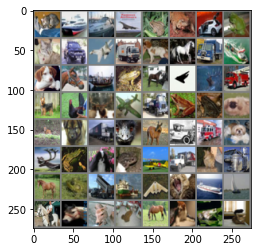

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




Classic images under PGD-attack : 


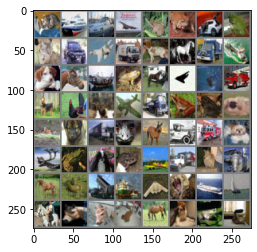



Exact labels : 
  cat  ship  ship plane

Classic Model predictions over initial dataset
  cat  ship   car plane

Classic Model predictions over attacked dataset
  dog   car   car   car


In [ ]:
images, labels = iter(testloader).next()

#labels_pred = net(images.to(DEVICE)).to('cpu').int().argmax(axis=1)
_, labels_pred = torch.max(net(images.to(DEVICE)), 1)

images_att = pgd_attack(net, DEVICE, images.to(DEVICE), labels.to(DEVICE), torch.nn.CrossEntropyLoss(), nb_it=7)
distances = distance_plot_delta(images_att, images.to(DEVICE))
print(distances)

#labels_att = net(images_att).to('cpu').int().argmax(axis=1)
_, labels_att = torch.max(net(images_att), 1)

# show images
print("Classic images : ")
imshow(torchvision.utils.make_grid(images.to('cpu')), "1_8", "clean")
print("\n\nClassic images under PGD-attack : ")
imshow(torchvision.utils.make_grid(images_att.to('cpu')), "1_8", "pgd")

# print labels
print("\n\nExact labels : ")
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print("\nClassic Model predictions over initial dataset")
print(' '.join('%5s' % classes[labels_pred[j]] for j in range(4)))

print('\nClassic Model predictions over attacked dataset')
print(' '.join('%5s' % classes[labels_att[j]] for j in range(4)))

#### Testing our classic model over Attacked data

In [ ]:
total = 0
correct_att = 0
correct = 0

#with torch.no_grad():
for data in testloader :
  inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
  inputs_att = pgd_attack(net, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss(), nb_it=7)
  
  outputs = net(inputs)
  outputs_att = net(inputs_att)

  _, predicted = torch.max(outputs.data, 1)
  _, predicted_att = torch.max(outputs_att.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
  correct_att += (predicted_att == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

print('Accuracy of the network on the 10000 test Attacked images: %d %%' % (
    100 * correct_att / total))

Accuracy of the network on the 10000 test images: 68 %
Accuracy of the network on the 10000 test Attacked images: 8 %


#### Results

In [ ]:
acc_pgd = []
test = data_loading(testset, 0.1, 64, training=False)


range_eta = [i/1000 for i in range(0,13)]
range_epsilon = [i/1000 for i in range(0, 27, 3)]


for eta in tqdm(range_eta) :
    for eps in range_epsilon :
        #with torch.no_grad():
        count = 0
        accur = []

        total = 0
        correct_att = 0
        
        for data in test :
            inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            inputs_att = pgd_attack(net, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss(), nb_it=7, eta=eta, epsilon=eps)

            outputs_att = net(inputs_att.to(DEVICE))
            _, predicted_att = torch.max(outputs_att.data, 1)
            total += labels.size(0)
            correct_att += (predicted_att == labels).sum().item()

        acc_pgd.append( [eps, eta, 100 * correct_att / total] )

  0%|          | 0/13 [00:00<?, ?it/s]


Loading of the Test set !


100%|██████████| 13/13 [10:08<00:00, 46.80s/it]


#### Plot of the results

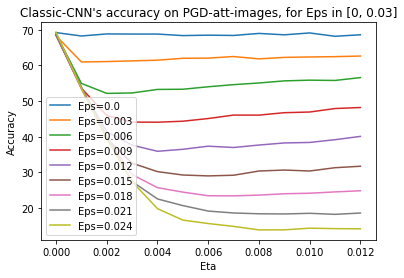

In [ ]:
accs = np.array(acc_pgd)
accs[:,2] = accs[:,2]
done = []
plt.figure()
for e in accs[:,0] :
    
    if e not in done :
        abscisse = accs[accs[:,0]==e,1] #/255
        abscisse = [round(a, 3) for a in abscisse]
        ordonnee = accs[accs[:,0]==e,2]
        #plt.scatter(abscisse, ordonnee, color='green', label="Accuracy")
        plt.plot(abscisse, ordonnee, label="Eps={}".format(round(e, 3)))

    done.append(e)

plt.title( "Classic-CNN's accuracy on PGD-att-images, for Eps in [0, 0.03]")
plt.xlabel("Eta")
plt.ylabel("Accuracy")
plt.legend()
name = "PLOT_2_acc_eps_eta.png"
plt.savefig(name, dpi=1000)
plt.show()
plt.close()

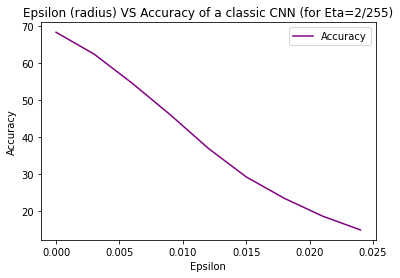

In [ ]:
#epss = accs[accs[:,1]==2/255,0]
#vals = set(accs[:,1])
#for v in vals : 
#  acc_plot = accs[accs[:,1]==round(2/255, 3),2]
#plt.plot(acc_plot)


epss = accs[accs[:,1]==0.007,0] #/ 255
acs = accs[accs[:,1]==0.007,2]
plt.plot([round(a, 3) for a in epss], acs, color='purple', label="Accuracy")
plt.legend()
plt.title( "Epsilon (radius) VS Accuracy of a classic CNN (for Eta=2/255)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.savefig("EPS_2_ACCU.png", dpi=1000)
plt.show()

In [ ]:
acc_pgd = []
#net.load_state_dict(torch.load(PATH))
test = data_loading(testset, 0.1, 64, training=False)

for nbIT in tqdm(range(0, 11)) :

    total = 0
    correct_att = 0
    
    for data in test :
        inputs, labels = data[0].to(DEVICE), data[1].to(DEVICE)
        inputs_att = pgd_attack(net, DEVICE, inputs, labels, torch.nn.CrossEntropyLoss(), nb_it=nbIT, eta=2/255, epsilon=8/255)

        #if np.random.uniform() <= 0.1 : 
        #    imsave(torchvision.utils.make_grid(inputs.to('cpu')), "eps_"+str(eps)+"_eta_"+str(eta), "clean")
        #    imsave(torchvision.utils.make_grid(inputs_att.to('cpu')), "eps_"+str(eps)+"_eta_"+str(eta), "pgd")

        outputs_att = net(inputs_att.to(DEVICE))
        _, predicted_att = torch.max(outputs_att.data, 1)
        total += labels.size(0)
        correct_att += (predicted_att == labels).sum().item()

    acc_pgd.append( 100 * correct_att / total )

  0%|          | 0/11 [00:00<?, ?it/s]


Loading of the Test set !


100%|██████████| 11/11 [00:48<00:00,  4.38s/it]


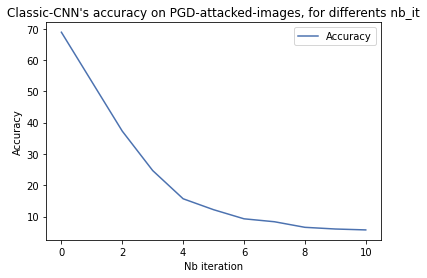

In [ ]:
plt.style.use('seaborn-deep')
plt.plot(acc_pgd, label='Accuracy')
plt.title( "Classic-CNN's accuracy on PGD-attacked-images, for differents nb_it")
plt.xlabel("Nb iteration")
plt.ylabel("Accuracy")
plt.legend()
name = "PLOT_nbIT_Accu.png"
plt.savefig(name, dpi=1000)
plt.show()
plt.close()